# "Penney's Game, pt. 2"
> "The waiting (time) is the hardest part"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [probability, simulation, monte-carlo, penneys-game, counterintuitive]
- hide: false
- image: images/stack_of_pennies.jpg
- search_exclude: false
- metadata_key1: simulation
- metadata_key2: probability

# Reimagining Penney's Game

We'll start with a modified version of [Penney's Game](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/05/penneys-game-1.html). As before, you're playing a game involving a sequence of coin flips -- but this time, you're playing it *alone.* You have chosen a sequence of three coin flips (let's say, HTH), and you're waiting to see how long it will take to encounter your sequence.

If your sequence of coins was 

<p style="text-align: center;">THTT<font color = "red">HTH</font></p>

then it would have taken you 7 coin flips to find the sequence you wanted. Clearly, if you're lucky, you might encounter your sequence in the first three flips; on the other hand, if you're unlucky, it could take a hundred coin flips for you to see your sequence. The question is: **does the choice of sequence affect how long it will take you to encounter it, on average?**

# The Incorrect Answer

Much like the first Penney's Game question, a little knowledge is a dangerous thing. In a fixed collection of 3 coin flips, each sequence of length three has a $\frac{1}{2^3} = \frac 1 8$ chance of occurring. When I first heard this question, it seemed like a pretty clear application of a [geometric random variable](https://en.wikipedia.org/wiki/Geometric_distribution), and since the expected wait time for a $\operatorname{Geometric(p)}$ random variable is $1/p$, it made sense to me that **each sequence might have the same wait time**.

And yet...

In [1]:
#collapse_output

library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr)
options(repr.plot.width=10, repr.plot.height=6)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




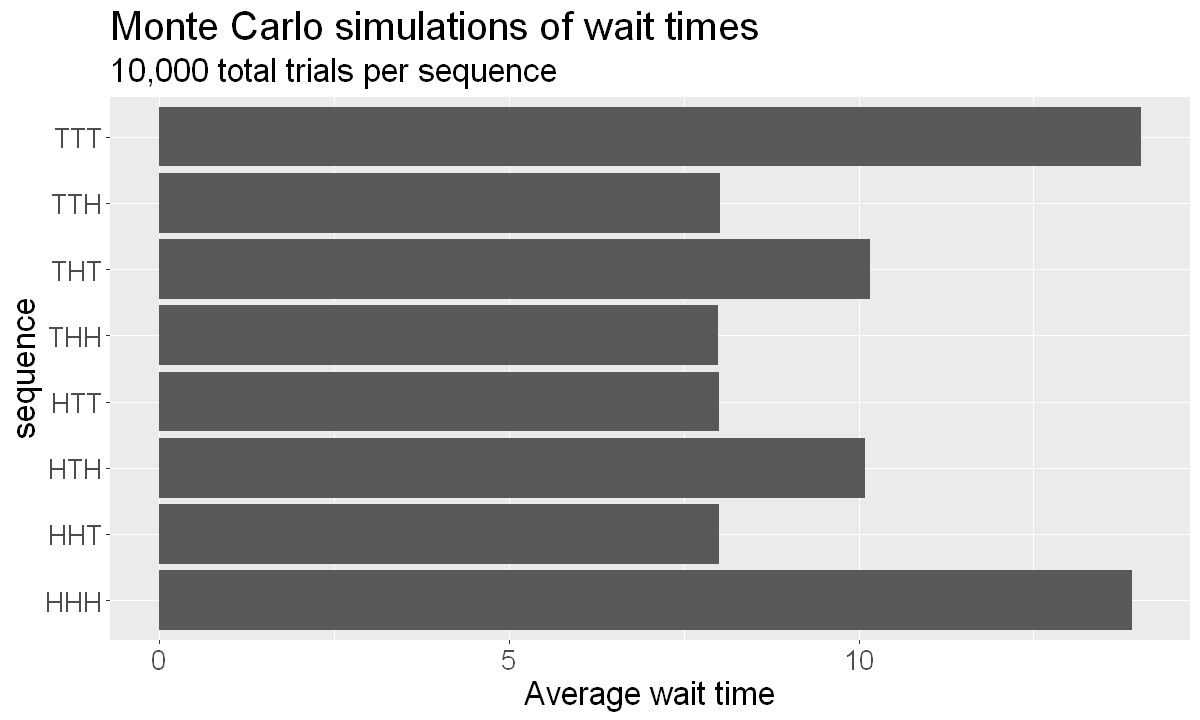

In [11]:
penney_wait <- function(p1){
    # p1 is a string like "HHT"
  
  coins <- nchar(p1)                # keep track of how many coins needed
  p1 <- unlist(str_split(p1, ""))   # split string into vector w/ length == coins
    
  flips <- sample(c("H", "T"), coins, replace = T) 
    # initialize flips with first collection of coin flips
    
  num_flips <- coins                # keep track of how many flips have happened
    
    # on each pass of the while loop, push the first n-1 coins forward in the list,
    # then sample a new coin for the nth one; for instance, HTH becomes TH? where
    # "?" is the result of a new coin flip
    
  while(!all(p1 == flips)){
    flips[1:(coins - 1)] <- flips[2:coins]
    flips[coins] <- sample(c("H", "T"), 1)
    num_flips <- num_flips + 1
  }
    
  num_flips                         # output number of flips required to find sequence
}


# The next function produces a vector of appropriate length enumerating all
# possible sequences of coin flips of that length; for instance, ht_iterator(2)
# will return the vector c("HH", "HT", "TH", "TT"). This works recursively by 
# calling ht_iterator(k-1), duplicating it, and appending each of H and T to 
# one of the duplicates.

ht_iterator <- function(k){
  if(k == 1) {
    return(c("H", "T"))
  } else {
    ht_iterator(k-1) %>%
      rep(each = 2) %>%
      paste0(c("H", "T"))
  } 
}

tibble(sequence = ht_iterator(3)) %>%
  rowwise() %>%
  mutate(avg_wait = mean(replicate(1e4, penney_wait(sequence)))) %>%
  ggplot(aes(x = sequence, y = avg_wait)) +
    geom_bar(stat = "identity") +
    labs(title = "Monte Carlo simulations of wait times",
         subtitle = "10,000 total trials per sequence",
         y = "Average wait time") +
    theme(text = element_text(size = 20)) +
    coord_flip()

Of course, I wasn't thinking through the fact that this clearly *isn't* a geometric random variable of that structure, since we don't need the sequences to fit inside *predetermined blocks of three*. In the above example, our sequence of coin flips was:

<p style="text-align: center;">THT|T<font color = "red">HT</font>|<font color = "red">H</font>..|</p>

Adopting the geometric perspective would be tantamount to requiring that the sequences occur strictly between the vertical bars -- but that doesn't need to happen here. 

# The Correct Answer

As we can see clearly from the graph, **different sequences have different average wait times**, and it follows that something about the non-geometricness of the process is the root cause. However, it may not be obvious at first what it is about being non-geometric would cause this discrepancy between sequences. As suggested by the graphs above, there are three tiers of expected wait times in the Penney's Game problem with three coins:

coin|avg. wait time
---|---
HHH, TTT|14
HTH, THT|10
HHT, HTT, THH, TTH|8

# But why?

The simulation clearly shows that there's a difference in wait times, but it doesn't do much to illuminate the reason for it. For that, we need to think carefully about what happens when we're chasing a sequence and we *don't* see what we are hoping for. We will illustrate this concept with some diagrams, starting with HHH.

![](https://github.com/aaron-montgomery/blog/blob/master/images/markov_hhh.jpg?raw=true)

The above diagram illustrates the collection of possible things that can occur when we're trying to complete the HHH sequence. When we begin, we want to see three flips of heads in a row. Each successive flip of H moves us to the right along the diagram. But if at any point we miss and see a T, we lose all our progress and have to start over from scratch.

![](https://github.com/aaron-montgomery/blog/blob/master/images/markov_hth.jpg?raw=true)

Through this perspective, we can start to see why HTH is a fundamentally friendlier sequence to chase than HHH. If we have obtained the first H in the sequence, we hope that the next throw will be a T; however, if it isn't, then it's an H instead. This means that when we're at step 1 of 3 in completing the sequence, missing the coin we hope to see just means we remain at step 1 instead of resetting all the way back to the start.

![](https://github.com/aaron-montgomery/blog/blob/master/images/markov_hht.jpg?raw=true)

The HHT case is even more favorable; here, once we see two consecutive H's, there's no way to lose our progress; we're just waiting for the eventual trailing T.

Examining these three cases carefully gives a useful perspective: **the secret is in the blue backtracking arrows.** Let's recap what blue arrows we've seen in the diagrams above:

- HHH
    - one loop 
    - two blue arrows (one long, one short)
  
- HTH
    - two loops
    - one long blue arrow
  
- HHT
    - two loops
    - one short blue arrow
  
This shows us that HHH has the most backtracking, HTH has the second most, and HHT has the least, which corresponds to their respective average wait times. This should make sense; the wait time will be determined not by what happens when you get the coin throws you want, but by how far your progress is set back when you *don't* get what you want.

(NB: Hopefully, this argument makes it clear why some wait times are longer than others; however, it falls short of establishing that those wait times are exactly 8, 10, and 14. I'll save those details for another post.)

# To be continued....

In the [first post](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/05/penneys-game-1.html) on Penney's Game, we saw that different sequences have various advantages over each other in a head-to-head matchup; now, we've also seen that different sequences have different expected wait times in isolation. To me, these two things are already plenty strange -- and yet, somehow, things will get even more bizarre when we put a fourth coin in the mix.